In [2]:
# this file is for running the line-fitting models and plot the best-fitting results 
import numpy as np
from astropy.io import fits
import os, sys
# from veremisfitting.line_fitting_exec import *
# from veremisfitting.line_fitting_model import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models,fitting
import astropy.units as u
import astropy.constants as const

%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep
import glob
import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')

import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')

from astropy.table import Table
import astropy.units as u

BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'
# define the absolute path of the current working directory
current_direc = os.getcwd() 

from msafit.fpa import PSFLib
import numpy as np
from msafit.model import Sersic
from msafit.fpa import Spec2D
from msafit.lsf import LSF
from copy import deepcopy
from msafit.model.config import get_default_config
import os

os.environ['msa_refdata'] = '/Users/zijianzhang/Documents/code/JWST_learning/NIRSpec/LSF_files/'
params = get_default_config()

shuterdict = {
    '1x1': '1x3',
    'x11': '1x3',
    '11x': '1x3',
    '1x11': '1x3',
    '11x1': '1x3',
    'x': '1x1',
    'x1': '1x3',
    '1x': '1x3',
}

def lsf_resolution(sp, wavelength):
    SHUTSTA = sp.meta['SHUTSTA']
    disire_psf_file = shuterdict[SHUTSTA] + '_' + sp.meta['GRATING'] + '_Q3_PSFLib.fits'
    print(disire_psf_file)

    params['instrument']['filter'] = sp.meta['FILTER']
    params['instrument']['disperser'] = sp.meta['GRATING']
    # SHUTSTA = sp.meta['SHUTSTA']

    psfs = PSFLib(disire_psf_file)

    # params["grid"]["x_grid"] = psfs.psf_x
    # params["grid"]["y_grid"] = psfs.psf_y
    # params["grid"]["wave_grid"] = psfs.psf_wave

    # params["morph"][0]["profile"] = "sersic"  # specify the profile
    # params["morph"][0]["flux"] = 1.           # integrated flux of the Sersic profile
    # params["morph"][0]["x0"] = 0            # offset in dispersion direction (pitch, not arcsec)
    # params["morph"][0]["y0"] = 0.0           # offset in cross-dispersion direction (pitch, not arcsec)
    # params["morph"][0]["r_e"] = 0.03           # this is in arcsec
    # params["morph"][0]["n"] = 4             # Sersic index
    # params["morph"][0]["q"] = 1             # axis ratio
    # params["morph"][0]["PA"] = 90             # rotation angle wrt positive x-axis 
    #                                           # (note: differs from e.g. the galfit default)
    params["grid"]["x_grid"] = psfs.psf_x
    params["grid"]["y_grid"] = psfs.psf_y
    params["grid"]["wave_grid"] = psfs.psf_wave

    params["morph"][0]["profile"] = "sersic"  # specify the profile
    params["morph"][0]["flux"] = 1.           # integrated flux of the Sersic profile
    params["morph"][0]["x0"] = 0            # offset in dispersion direction (pitch, not arcsec)
    params["morph"][0]["y0"] = 0.0           # offset in cross-dispersion direction (pitch, not arcsec)
    params["morph"][0]["r_e"] = 0.3           # this is in arcsec
    params["morph"][0]["n"] = 0.5             # Sersic index
    params["morph"][0]["q"] = 1             # axis ratio
    params["morph"][0]["PA"] = 90             # rotation angle wrt positive x-axis 
                                              # (note: differs from e.g. the galfit default)

    # create a model cube I(x,y,lambda)
    model = Sersic(params)
    model(params["grid"]["wave_grid"])
    # print(model.data.shape)


    spec = Spec2D(params)
    throughput = spec.make_spec2d(model,psfs,return_fluxes=True)

    params_2 = deepcopy(params)
    params_2["geometry"]["shutter_j"] = params["geometry"]["shutter_j"] - 1
    params_2["geometry"]["source_shutter"] = -1
    spec_2 = Spec2D(params_2)
    spec_2.make_spec2d(model,psfs)

    params_3 = deepcopy(params)
    params_3["geometry"]["shutter_j"] = params["geometry"]["shutter_j"] + 1
    params_3["geometry"]["source_shutter"] = 1
    spec_3 = Spec2D(params_3)
    spec_3.make_spec2d(model,psfs)


    # we provide our 3 nods to the LSF class
    # we only provide the wavelengths of interest (wl_fpa) and corresponding detector (x_fpa) coordinates once
    lsf = LSF([spec,spec_2,spec_3],spec.wl_fpa,spec.x_fpa)
    # lsf = LSF([spec],spec.wl_fpa,spec.x_fpa)
    fit_output = lsf.compute_lsf()
    # fit_output
    # print('resolution at 2.52 micron =', lsf.resolution(3.52e4))
    # print('dispersion at 1.78 micron =', lsf.dispersion_kms(3.78e4), 'km/s')
    return float(lsf.dispersion_kms(wavelength))#, lsf.resolution(wavelength)




grizli version: 1.12.9
msaexp version: 0.9.2


In [4]:
nrs = Table.read('../catalog/DJA_NIRSpec.csv')

selectedlrd_cat = Table.read('../catalog/all_nirspec_beta_withclassify_z2.ecsv')

jade_gal = Table.read('../catalog/jades_galaxies_sfr_withspecphot_DJA.csv')
nakajima_gal = Table.read('../catalog/Nakajima23_galaxies_phot_DJA.csv')
# nrs = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/UDS_lrd_catalog.txt', format='ascii')
# nrs = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/all_lrd_catalog.txt', format='ascii')


savetop_ = '../LRD/'
spec_dir = current_direc + '/example_inputs/'
os.makedirs(savetop_, exist_ok=True) 
Grating = np.array([i.split('_')[1] for i in nrs['file']])

# id = '58975' # remarkable z=9
# ymax = [1, 0.2, 0.7, 0.7]
# xlimits = [(0.5, 5.4), (0.5, 2.2), (3.9, 4.6), (5.0, 5.3)]

# id = '35180' # bright z=1.8
# ymax = [2]*4
srcid_set = np.unique(nrs['srcid'])
uid_set = np.unique(selectedlrd_cat['uid'])
jade_gal_uid = np.unique(jade_gal['uid'])
nakajima_gal_uid = np.unique(nakajima_gal['uid'])

srcid = nrs['srcid']
uid = nrs['uid']
id = '40579' # z=4.1
ymax = [0.8, 0.4, 0.8, 0.8]
xlimits = [(0.5, 5.4), (0.5, 2.2), (2.2, 2.8), (3.18, 3.6)]


In [5]:
print(len(nrs['uid']))
print(len(np.unique(nrs['uid'])))

26077
14909


In [ ]:
high_res_num = 0
for thisid in srcid_set:
    src = srcid == thisid
    # grating = Grating[src][0]

    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    
    sobj = {}
    for url in urls:
        while True:
            try:
                # print(f'Read {url}')
                key = os.path.basename(url)
                sobj[key] = msaexp.spectrum.SpectrumSampler(url)
                break
            except:
                print('retry')
                continue
      

    for j, k in enumerate(sobj):
        if 'g395m' not in k and 'g395h' not in k and 'g235m' not in k:
            high_res_num += 1
            break
print(high_res_num)

retry


6.7851
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_927271.spec.fits
rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits


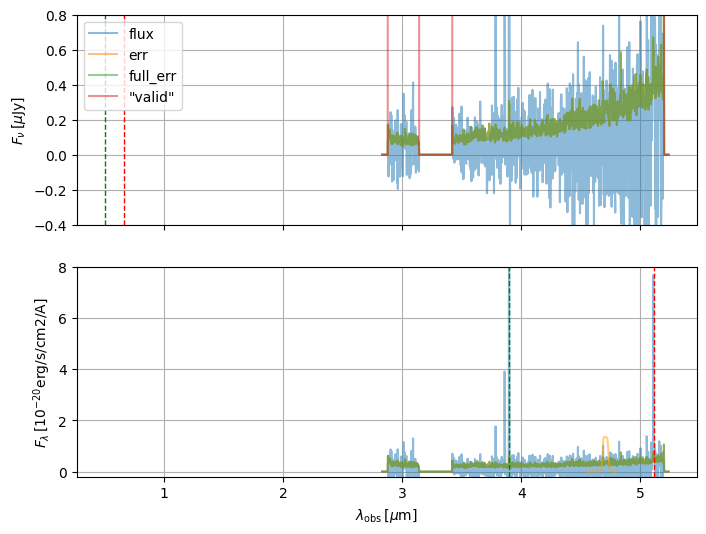

In [4]:
thisid = 8219
src = np.array(uid == thisid)
grating = Grating[src][0]

urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
print(z)
# Open the files into 1D objects, directly from the web
sobj = {}
for url in urls:
    print(f'Read {url}')
    key = os.path.basename(url)
    sobj[key] = msaexp.spectrum.SpectrumSampler(url)

for j, k in enumerate(sobj):
    if '395' in k:
        break
# k = 'rubies-egs63-nod-v3_prism-clear_4233_47179.spec.fits'
print(k)

sp = sobj[k]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1,figsize=(8,6), sharex=True)
ax = axes[0]
ymax = [8, 4, 8, 8]
for c in ['flux','err','full_err']:
    ax.plot(sp.spec_wobs, sp.spec[c], alpha=0.5, label=c)
#ax.plot(sp.spec_wobs, sp.spec['err'], alpha=0.5, label='err')
#ax.plot(sp.spec_wobs, sp.spec['full_err'], alpha=0.5, label='full_err')
ax.axvline(x = 0.6568, color='r', linestyle='--', lw = 1)
ax.axvline(x = 0.5007, color='g', linestyle='--', lw = 1)
ax.set_ylim(-0.1*ymax[1], ymax[1]/5)
ax.plot(sp.spec_wobs, sp.valid*ymax[1]*0.8, alpha=0.5, label='"valid"')
ax.grid()
ax.legend()
ax.set_ylabel(r'$F_\nu\,[\mu\mathrm{Jy}]$')
ax = axes[1]
for c in ['flux','err','full_err']:
    ax.plot(sp.spec_wobs, sp.spec[c]*sp.spec['to_flam'], alpha=0.5, label=c)
ax.set_ylim(-0.01*ymax[1]*5, ymax[1]*2)
ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm2/A}]$')
ax.grid()
ax.axvline(x = 0.6568*(1+z), color='r', linestyle='--', lw = 1)
ax.axvline(x = 0.5007*(1+z), color='g', linestyle='--', lw = 1)
ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')

def read_filter_data(filename):
    data = np.loadtxt(filename, skiprows=1)
    wavelength = data[:, 0]
    throughput = data[:, 1]
    return wavelength, throughput

file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/nircam_throughputs/mean_throughputs/'  + 'F470N_throughput.txt'

wavelength, throughput = read_filter_data(file)

ax.plot(wavelength/1e4, throughput*4, color='orange', linestyle='-', alpha=0.5, label='F470N_throughput')
# ax.set_xlim([4., 4.8])


In [11]:
from scipy.integrate import simps
import numpy as np
from astropy.modeling import models, fitting
from astropy.constants import c
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import lmfit
from lmfit.models import GaussianModel, ConstantModel
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.constants as spy_const  # 光速 (m/s)
from lmfit import minimize

cosmo = FlatLambdaCDM(H0=69.6 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.286)


def convolve_with_lsf(model_flux, v_axis, sigma_lsf):
    """
    使用 astropy 进行 LSF 卷积
    :param model_flux: 原始模型光谱（在速度空间）
    :param v_axis: 速度轴
    :param lsf: LSF 对象，提供 resolution(wrange)
    :param wrange: 对应的波长范围
    :return: 经过 LSF 卷积的模型光谱
    """
    # 计算 LSF 贡献的标准差 (km/s)
    # R = lsf.resolution(wrange)  # LSF 分辨率
    # sigma_lsf = (spy_const.c / 1000) / (R * np.sqrt(8 * np.log(2)))  # c 换算成 km/s
    

    # 计算 LSF 核的宽度 (转换到速度空间的点数)
    dv = np.mean(np.diff(v_axis))  # 速度步长 (km/s)
    sigma_pixels = np.max(sigma_lsf) / dv  # 在速度轴上的 sigma

    # 生成高斯核
    gaussian_kernel = Gaussian1DKernel(stddev=sigma_pixels)

    # 进行 LSF 卷积
    convolved_flux = convolve(model_flux, gaussian_kernel, boundary='extend')

    return convolved_flux


class EmissionLineFitter:
    def __init__(self, sp, z, reference_wavelength, fit_line_id=None):
        self.sp = sp
        self.z = z
        self.reference_wavelength = reference_wavelength
        self.obs_wavelength = reference_wavelength * (1 + z)
        self.fit_line_id = fit_line_id
        self.gaussians = []
        self.component_results = {}
        self.auto_bounds = False
        self.max_flux = None
        self._prepare_data()
        self.lm_model = None
        self.lm_params = lmfit.Parameters()
        self.fit_result = None

    def _prepare_data(self):
        mask = self.sp.valid > 0
        self.w_obs = self.sp.spec_wobs[mask] / (1 + self.z) * 10000
        self.flux = self.sp.spec['flux'][mask] * self.sp.spec['to_flam'][mask] * (1 + self.z) #* 1e-20
        self.flux_err = self.sp.spec['err'][mask] * self.sp.spec['to_flam'][mask] * (1 + self.z) #* 1e-20
        self.max_flux = np.max(self.flux)
        self.v_obs = (self.w_obs - self.reference_wavelength) / self.reference_wavelength * c.to('km/s').value

    def slice_region(self, velocity_range):
        idx = np.where((self.v_obs >= -velocity_range) & (self.v_obs <= velocity_range))
        self.w_sliced = self.w_obs[idx] * 10000
        self.flux_sliced = self.flux[idx]
        self.flux_err_sliced = self.flux_err[idx]
        self.v_sliced = self.v_obs[idx]

    def set_gaussian_components(self, num_components, initial_params):
        self.lm_params = lmfit.Parameters()
        # Continuum component
        self.lm_params.add('cont_c', value=np.median(self.flux_sliced), min=0)
        
        # Gaussian components
        self.gaussians = []
        sigma_names = {}  # 存储每个高斯的 sigma 参数名
        center_names = {}  # 存储每个高斯的 center 参数名
        for i in range(num_components):
            prefix = f'g{i}_'
            params = initial_params[i]
            # print(params.get('amp_bounds', (0, None))[0], params.get('amp_bounds', (0, None))[1])
            self.lm_params.add(f'{prefix}amplitude', value=params['amplitude'], 
                              min=params.get('amp_bounds', (0, None))[0],
                              max=np.inf)
                            #    min=0,
                            #   max=1, vary=True)
            # self.lm_params.add(f'{prefix}center', value=params['mean'],
            #                   min=params.get('mean_bounds', (-np.inf, np.inf))[0],
            #                   max=params.get('mean_bounds', (-np.inf, np.inf))[1])
            # self.lm_params.add(f'{prefix}sigma', value=params['stddev'],
            #                   min=params.get('std_bounds',  (0, None))[0],
            #                   max=params.get('std_bounds',  (0, None))[1])
            # 处理 sigma 绑定
            sigma_name = f'{prefix}sigma'
            tied_sigma = params.get('tied_sigma', None)
            tied_center = params.get('tied_center', None)
            tied_center_value = params.get('tied_center_value', None)
        

            if tied_sigma is not None:  # 绑定 sigma
                tied_sigma_name = sigma_names.get(tied_sigma)
                if tied_sigma_name:
                    self.lm_params.add(sigma_name, expr=tied_sigma_name)  # 绑定到已有 sigma
                else:
                    raise ValueError(f"Invalid tied_sigma index {tied_sigma} for Gaussian {i}")
            else:  # 独立 sigma
                self.lm_params.add(sigma_name, value=params['stddev'],
                                   min=params.get('std_bounds', (0, None))[0],
                                   max=params.get('std_bounds', (0, None))[1])
                sigma_names[i] = sigma_name  # 记录 sigma 名字，以便绑定

            
            if 'center_diff_range' in params:  # 检查是否有差距约束
                diff_range = params['center_diff_range']
                if len(diff_range) == 2:
                    lower, upper = diff_range
                    delta_initial = (upper + lower) / 2  # 初始差距
                    # 为 center 设置差距约束：确保其差距在给定范围内
                    if i > 0:  # 只有在 i > 0 时，才与其他高斯建立差距约束
                        # expr = f"abs(g{i}_center - g0_center) >= {lower} & abs(g{i}_center - g0_center) <= {upper}"
                        self.lm_params.add(f'delta{i}', value=delta_initial, min = lower, max=upper, vary=True)
                        self.lm_params.add(f'{prefix}center', value=params['mean'],
                              min=params.get('mean_bounds', (-np.inf, np.inf))[0],
                              max=params.get('mean_bounds', (-np.inf, np.inf))[1], expr  = f'g0_center + delta{i}')
            elif tied_center is not None:  # 绑定 center
                tied_center_name = center_names.get(tied_center)
                if tied_center_name:
                    if(tied_center_value > 0):
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name  +  f' + {tied_center_value}')
                    elif(tied_center_value < 0):
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name  +  f' - {-tied_center_value}')
                    else:
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name)
                else:
                    raise ValueError(f"Invalid tied_center index {tied_center} for Gaussian {i}")
            else:  # 独立 center
                self.lm_params.add(f'{prefix}center', value=params['mean'],
                              min=params.get('mean_bounds', (-np.inf, np.inf))[0],
                              max=params.get('mean_bounds', (-np.inf, np.inf))[1])
                center_names[i] = f'{prefix}center'  # 记录 center 名字，以便绑定
             #处理中心差距约束

            self.gaussians.append(GaussianModel(prefix=prefix))

        # Build composite model
        self.lm_model = ConstantModel(prefix='cont_')
        for g in self.gaussians:
            self.lm_model += g

      

    def fit_emission_line(self, use_monte_carlo=True):
        # First fit continuum+gaussians
        
        # ----------------------
        # def residuals(params, x, y, y_err, sigma_lsf):
        #     """计算 (数据 - LSF修正后的模型) / 误差"""
        #     model_flux = self.lm_model.eval(params, x=x)  # 计算原始模型
        #     model_flux_lsf = convolve_with_lsf(model_flux, x, sigma_lsf)  # 进行 LSF 卷积
        #     return (y - model_flux_lsf) / y_err  # 计算归一化残差

        # # 使用 lmfit 的 minimize 进行拟合
        # self.fit_result = minimize(
        #     residuals, self.lm_params, args=(self.v_sliced, self.flux_sliced, 
        #                                      self.flux_err_sliced, self.sigma_lsf)
        # )
        # ----------------------
        self.fit_result = self.lm_model.fit(self.flux_sliced, self.lm_params, x=self.v_sliced, weights=1/self.flux_err_sliced, method='least_squares')  # 计算协方差

        
        # Subtract continuum
        self.cont_value = self.fit_result.params['cont_c'].value
        self.flux_sliced_contsub = self.flux_sliced - self.cont_value
        
        # # Fit gaussians to continuum-subtracted data
        # gauss_model = reduce(add, [g for g in self.gaussians])
        # gauss_params = result.params.copy()
        # gauss_params.pop('cont_c')  # Remove continuum parameter
        
        # self.fit_result = gauss_model.fit(self.flux_sliced_contsub, gauss_params, 
        #                                  x=self.v_sliced, weights=1/self.flux_err_sliced)
        
        # Calculate statistics
        model_flux = self.cont_value + self.fit_result.best_fit
        residuals = self.flux_sliced - model_flux
        
        # model_flux = self.lm_model.eval(self.fit_result.params, x=self.v_sliced)
        # model_flux_lsf = convolve_with_lsf(model_flux, self.v_sliced, self.sigma_lsf)
        # residuals = self.flux_sliced - model_flux_lsf
        
        # self.chi2 = np.sum((residuals / self.flux_err_sliced) ** 2)
        # self.reduced_chi2 = self.chi2 / (len(residuals) - len(self.fit_result.params))
        self.chi2 = self.fit_result.chisqr
        self.reduced_chi2 = self.fit_result.redchi
        self.BIC = self.fit_result.bic
        self.AIC = self.fit_result.aic
        
        # Handle parameter errors
        if self.fit_result.errorbars and not use_monte_carlo:
            self.parameter_errors = np.array([self.fit_result.params[p].stderr 
                                             for p in self.fit_result.var_names])
        # else:
        #     self.estimate_errors_monte_carlo()
        
        return self.fit_result, self.chi2, self.reduced_chi2

    def calculate_flux_ew_fwhm(self,  guass_or_lorentz='gauss'):
        sigma_lsf = lsf_resolution(sp, self.obs_wavelength)
        self.sigma_lsf = sigma_lsf

        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        wave_high_res = x_high_res * self.reference_wavelength / c.to('km/s').value + self.reference_wavelength
        # cont_flux = self.fitted_cont(x_high_res)
        cont_flux = self.cont_value * np.ones_like(x_high_res)

        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            params = self.fit_result.params
            amp = params[f'{prefix}amplitude'].value
            amp_err = params[f'{prefix}amplitude'].stderr or 0
            width_v = params[f'{prefix}sigma'].value
            width_v_err = params[f'{prefix}sigma'].stderr or 0
            de_convoved_width = np.sqrt(width_v**2 - self.sigma_lsf**2)
            # de_convoved_width_err = np.sqrt((width_v_err/width_v)**2 + (sigma_lsf/width_v)**2) * de_convoved_width
            de_convoved_width_err = np.sqrt((width_v * width_v_err)**2 ) / de_convoved_width
            # params[f'{prefix}de_convoved_width'] = de_convoved_width
            # params[f'{prefix}de_convoved_width_err'] = de_convoved_width_err

            peak = 0.3989423*amp / (width_v)
            peak_err = peak * np.sqrt((amp_err/amp)**2 + (width_v_err/width_v)**2)
            width_AA = width_v * self.reference_wavelength / const.c.to('km/s').value
            width_err_AA = width_v_err * self.reference_wavelength / const.c.to('km/s').value

            # Calculate flux and flux error
            flux = peak * width_AA * np.sqrt(2 * np.pi)
            # print(np.sqrt((peak_err / peak) ** 2 + (width_err / width) ** 2))
            flux_err = flux * np.sqrt((peak_err / peak) ** 2 + (width_err_AA / width_AA) ** 2) if peak != 0 and width_AA != 0 else 0.0
    
            # calculate luminosity
            lumdis = cosmo.luminosity_distance(self.z)
            luminosity = flux * 4 * np.pi * lumdis.to('cm').value ** 2
            luminosity_err = flux_err * 4 * np.pi * lumdis.to('cm').value ** 2

            # Calculate EW and EW error
            # model_flux = gaussian(x_high_res)
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            r_i_all = (-model_flux) / cont_flux
            ew_all = np.abs(simps(r_i_all, wave_high_res))
    
            delta_x_median = np.median(np.diff(wave_high_res))
            epsilon_all = np.sqrt(np.sum((r_i_all - np.mean(r_i_all)) ** 2) / len(r_i_all))
            if guass_or_lorentz == 'gauss':
                ew_all_err = 2.45 * np.sqrt(width_AA * delta_x_median) * epsilon_all
            elif guass_or_lorentz == 'lorentz':
                ew_all_err = 2.74 * np.sqrt(width_AA * delta_x_median) * epsilon_all
            else:
                raise ValueError("Invalid profile type. Choose 'gauss' or 'lorentz'.")
    
            # Calculate FWHM and FWHM error
            fwhm = 2.35482 * np.abs(width_v)
            fwhm_err = 2.35482 * width_v_err
            de_convoved_fwhm = 2.35482 * de_convoved_width
            de_convoved_fwhm_err = 2.35482 * de_convoved_width_err
    
            # Store results
            self.component_results[f"Gaussian {i + 1}"] = {
                "Flux": flux*1e-20,
                "Flux_Error": flux_err*1e-20,
                "Luminosity": luminosity*1e-20,
                "Luminosity_Error": luminosity_err*1e-20,
                "EW": ew_all,
                "EW_Error": ew_all_err,
                "FWHM": fwhm,
                "FWHM_Error": fwhm_err,
                "intrinsic FWHM": de_convoved_fwhm,
                "intrinsic FWHM_Error": de_convoved_fwhm_err
            }
    
        # Print results
        for component, results in self.component_results.items():
            print(f"{component}:")
            print(f"  Flux      = {results['Flux']:.3e} ± {results['Flux_Error']:.3e} erg/cm^2/s")
            print(f"  Luminosity= {results['Luminosity']:.3e} ± {results['Luminosity_Error']:.3e} erg/s")
            print(f"  EW        = {results['EW']:.2f} ± {results['EW_Error']:.2f} Å")
            print(f"  FWHM      = {results['FWHM']:.2f} ± {results['FWHM_Error']:.2f} km/s")
            print(f"  intrinsic FWHM      = {results['intrinsic FWHM']:.2f} ± {results['intrinsic FWHM_Error']:.2f} km/s")
            print("-" * 40)

    # def save_results_to_txt(self, filename):
    #     """
    #     Save flux, EW, FWHM results with errors to a text file, along with Gaussian parameters and Chi-squared.

    #     Parameters:
    #     - filename: Path to the output text file.
    #     """
    #     with open(filename, 'w') as f:
    #         f.write(f"Results for Source ID: {self.fit_line_id}\n")
    #         f.write("=" * 40 + "\n")

    #         # Save Gaussian components information
    #         f.write(f"\nNumber of Gaussian Components: {len(self.gaussians)}\n")
    #         f.write("-" * 40 + "\n")

    #         # Loop over Gaussian components and save their parameters with errors
    #         # for i, gaussian in enumerate(self.fitted_gaussians):
    #         #     f.write(f"\nGaussian {i + 1} Parameters and Errors:\n")
    #         #     f.write(f"  Amplitude       = {gaussian.amplitude.value:.3e} ± {self.parameter_errors[i * 3]:.3e} erg/cm^2/s\n")
    #         #     f.write(f"  Mean (Velocity) = {gaussian.mean.value:.3f} ± {self.parameter_errors[i * 3 + 1]:.3f} km/s\n")
    #         #     f.write(f"  Stddev (Width)  = {gaussian.stddev.value:.3f} ± {self.parameter_errors[i * 3 + 2]:.3f} km/s\n")
    #         #     f.write("-" * 40 + "\n")
    #         # try:
    #         for i, prefix in enumerate([g.prefix for g in self.gaussians]):
    #             params = self.fit_result.params
    #             f.write(f"\nGaussian {i + 1} Parameters and Errors:\n")
    #             f.write(f"  Amplitude       = {params[f'{prefix}amplitude'].value:.3e} ± {params[f'{prefix}amplitude'].stderr:.3e} erg/cm^2/s\n")
    #             f.write(f"  peak           = {0.3989423*params[f'{prefix}amplitude'].value / params[f'{prefix}sigma'].value:.3e} ± {0.3989423*params[f'{prefix}amplitude'].stderr / params[f'{prefix}sigma'].value:.3e} erg/cm^2/s\n")
    #             f.write(f"  Mean (Velocity) = {params[f'{prefix}center'].value:.3f} ± {params[f'{prefix}center'].stderr:.3f} km/s\n")
    #             f.write(f"  Stddev (Width)  = {params[f'{prefix}sigma'].value:.3f} ± {params[f'{prefix}sigma'].stderr:.3f} km/s\n")
    #             de_convoved_width = np.sqrt(params[f'{prefix}sigma'].value**2 - self.sigma_lsf**2)
    #             # de_convoved_width_err = np.sqrt((params[f'{prefix}sigma'].stderr/params[f'{prefix}sigma'].value)**2 + (self.sigma_lsf/params[f'{prefix}sigma'].value)**2) * de_convoved_width
    #             de_convoved_width_err = params[f'{prefix}sigma'].value*params[f'{prefix}sigma'].stderr / de_convoved_width
    #             f.write(f"  Intrinsic Stddev (Width)  = {de_convoved_width:.3f} ± {de_convoved_width_err:.3f} km/s\n")
    #             f.write("-" * 40 + "\n")
    #         # except:
    #         #     pass

    #         # Save component flux, EW, and FWHM with errors
    #         f.write(f"\nComponent Results:\n")
    #         for component, results in self.component_results.items():
    #             f.write(f"{component}:\n")
    #             f.write(f"  Flux      = {results['Flux']:.3e} ± {results['Flux_Error']:.3e} erg/cm^2/s\n")
    #             f.write(f"  Luminosity= {results['Luminosity']:.3e} ± {results['Luminosity_Error']:.3e} erg/s\n")
    #             f.write(f"  EW        = {results['EW']:.2f} ± {results['EW_Error']:.2f} Å\n")
    #             f.write(f"  FWHM      = {results['FWHM']:.2f} ± {results['FWHM_Error']:.2f} km/s\n")
    #             f.write(f"  intrinsic FWHM      = {results['intrinsic FWHM']:.2f} ± {results['intrinsic FWHM_Error']:.2f} km/s\n")
    #             f.write("-" * 40 + "\n")

    #         # Save Chi-squared and reduced Chi-squared
    #         f.write(f"\nChi-squared (χ²): {self.chi2:.3f}\n")
    #         f.write(f"Reduced Chi-squared (χ²/dof): {self.reduced_chi2:.3f}\n")
    #         f.write(f"BIC: {self.BIC:.3f}\n")
    #         f.write(f"AIC: {self.AIC:.3f}\n")
    #         f.write("=" * 40 + "\n")
    def save_results_to_txt(self, filename):
        """
        Save flux, EW, FWHM results with errors to a text file, along with Gaussian parameters and Chi-squared.
        
        Parameters:
        - filename: Path to the output text file.
        """
        def safe_val_err(val, err, default_factor=1.0):
            """Return value and a safe error (use default if err is None)."""
            if err is None:
                err = abs(val) * default_factor
            return val, err
    
        with open(filename, 'w') as f:
            f.write(f"Results for Source ID: {self.fit_line_id}\n")
            f.write("=" * 40 + "\n")
    
            f.write(f"\nNumber of Gaussian Components: {len(self.gaussians)}\n")
            f.write("-" * 40 + "\n")
    
            for i, prefix in enumerate([g.prefix for g in self.gaussians]):
                params = self.fit_result.params
                f.write(f"\nGaussian {i + 1} Parameters and Errors:\n")
    
                # Amplitude
                amp_val, amp_err = safe_val_err(params[f'{prefix}amplitude'].value, params[f'{prefix}amplitude'].stderr)
                f.write(f"  Amplitude       = {amp_val:.3e} ± {amp_err:.3e} erg/cm^2/s\n")
    
                # Sigma
                sigma_val, sigma_err = safe_val_err(params[f'{prefix}sigma'].value, params[f'{prefix}sigma'].stderr)
    
                # Peak = amplitude / (sqrt(2pi) * sigma)
                peak_val = 0.3989423 * amp_val / sigma_val
                peak_err = 0.3989423 * amp_err / sigma_val  # 不考虑 sigma_err 的传播误差
                f.write(f"  peak           = {peak_val:.3e} ± {peak_err:.3e} erg/cm^2/s\n")
    
                # Center
                center_val, center_err = safe_val_err(params[f'{prefix}center'].value, params[f'{prefix}center'].stderr)
                f.write(f"  Mean (Velocity) = {center_val:.3f} ± {center_err:.3f} km/s\n")
    
                f.write(f"  Stddev (Width)  = {sigma_val:.3f} ± {sigma_err:.3f} km/s\n")
    
                # Intrinsic width
                try:
                    deconv_val = np.sqrt(sigma_val**2 - self.sigma_lsf**2)
                    deconv_err = sigma_val * sigma_err / deconv_val
                    f.write(f"  Intrinsic Stddev (Width)  = {deconv_val:.3f} ± {deconv_err:.3f} km/s\n")
                except Exception as e:
                    f.write(f"  Intrinsic Stddev (Width)  = N/A (error during deconvolution)\n")
                f.write("-" * 40 + "\n")
    
            f.write(f"\nComponent Results:\n")
            for component, results in self.component_results.items():
                f.write(f"{component}:\n")
                f.write(f"  Flux      = {results['Flux']:.3e} ± {results['Flux_Error']:.3e} erg/cm^2/s\n")
                f.write(f"  Luminosity= {results['Luminosity']:.3e} ± {results['Luminosity_Error']:.3e} erg/s\n")
                f.write(f"  EW        = {results['EW']:.2f} ± {results['EW_Error']:.2f} Å\n")
                f.write(f"  FWHM      = {results['FWHM']:.2f} ± {results['FWHM_Error']:.2f} km/s\n")
                f.write(f"  intrinsic FWHM      = {results['intrinsic FWHM']:.2f} ± {results['intrinsic FWHM_Error']:.2f} km/s\n")
                f.write("-" * 40 + "\n")
    
            f.write(f"\nChi-squared (χ²): {self.chi2:.3f}\n")
            f.write(f"Reduced Chi-squared (χ²/dof): {self.reduced_chi2:.3f}\n")
            f.write(f"BIC: {self.BIC:.3f}\n")
            f.write(f"AIC: {self.AIC:.3f}\n")
            f.write("=" * 40 + "\n")

    def save_fit_plot(self, filename, ifshow = False):
        """Save the fit plot to a file."""
        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        total_model = self.fit_result.eval(x=x_high_res)
        cont_component = self.cont_value * np.ones_like(x_high_res)

        fig, axes = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

        # Upper plot: Fit and components
        ax1 = axes[0]
        ax1.step(self.v_sliced, self.flux_sliced, where='mid', color='k', label='Data')
        ax1.fill_between(self.v_sliced, self.flux_sliced - self.flux_err_sliced, 
                         self.flux_sliced + self.flux_err_sliced, color='gray', alpha=0.5)
        
        ax1.plot(x_high_res, total_model, color='red', label='Total Model')
        ax1.plot(x_high_res, cont_component, color='blue', linestyle='--', label='Continuum')
        
        # for i, gaussian in enumerate(self.fitted_gaussians):
        #     gaussian_flux = gaussian(x_high_res)
        #     ax1.plot(x_high_res, gaussian_flux, linestyle=':', label=f'Gaussian {i + 1}')
        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            ax1.plot(x_high_res, model_flux, linestyle=':', label=f'Gaussian {i + 1}')

        ax1.set_ylabel(r"Flux ($10^{-20}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)", fontsize=14)
        ax1.legend(fontsize=12)
        ax1.set_title(self.fit_line_id + f'-{len(self.gaussians)}-Gaussian', fontsize=16)
        
        ax1.text(0.05, 0.9, f"$\chi^2/$dof = {self.reduced_chi2:.2f}", transform=ax1.transAxes, fontsize=12)
        ax1.text(0.05, 0.8, f"BIC = {self.BIC:.2f}", transform=ax1.transAxes, fontsize=12)
        ax1.text(0.05, 0.7, f"AIC = {self.AIC:.2f}", transform=ax1.transAxes, fontsize=12)

        # Lower plot: Residuals
        # residuals = self.flux_sliced - self.fitted_model(self.v_sliced) - self.fitted_cont(self.v_sliced)
        residuals = (self.flux_sliced - self.fit_result.best_fit)/self.flux_err_sliced
        ax2 = axes[1]
        ax2.step(self.v_sliced, residuals, where='mid', color='k', label='Residuals')
        ax2.axhline(0, color='red', linestyle='--')
        ax2.axhline(3, color='gray', linestyle='--')
        ax2.axhline(-3, color='gray', linestyle='--')
        ax2.set_xlabel(r"Velocity (km s$^{-1}$)", fontsize=14)
        ax2.set_ylabel("Residuals ($\sigma$)", fontsize=14)
        plt.tight_layout()
        plt.savefig(filename)
        if ifshow:
            plt.show()
        plt.close()

    def external_plot(self, axes):
        """Save the fit plot to a file."""
        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        total_model = self.fit_result.eval(x=x_high_res)
        cont_component = self.cont_value * np.ones_like(x_high_res)

        # Upper plot: Fit and components
        ax1 = axes[0]
        ax1.step(self.v_sliced, self.flux_sliced, where='mid', color='k', label='Data')
        ax1.fill_between(self.v_sliced, self.flux_sliced - self.flux_err_sliced, 
                         self.flux_sliced + self.flux_err_sliced, color='gray', alpha=0.5)
        
        ax1.plot(x_high_res, total_model, color='red', label='Total Model')
        ax1.plot(x_high_res, cont_component, color='blue', linestyle='--', label='Continuum')
        
        # for i, gaussian in enumerate(self.fitted_gaussians):
        #     gaussian_flux = gaussian(x_high_res)
        #     ax1.plot(x_high_res, gaussian_flux, linestyle=':', label=f'Gaussian {i + 1}')
        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            ax1.plot(x_high_res, model_flux, linestyle=':', label=f'Gaussian {i + 1}')

        
        ax1.legend(fontsize=18)
        ax1.set_title(self.fit_line_id + f' {len(self.gaussians)}-Gaussian', fontsize=20)
        
        ax1.text(0.05, 0.9, f"$\chi^2/$dof = {self.reduced_chi2:.2f}", transform=ax1.transAxes, fontsize=20)
        ax1.text(0.05, 0.8, f"BIC = {self.BIC:.2f}", transform=ax1.transAxes, fontsize=20)
        ax1.text(0.05, 0.7, f"AIC = {self.AIC:.2f}", transform=ax1.transAxes, fontsize=20)

        # Lower plot: Residuals
        # residuals = self.flux_sliced - self.fitted_model(self.v_sliced) - self.fitted_cont(self.v_sliced)
        residuals = (self.flux_sliced - self.fit_result.best_fit)/self.flux_err_sliced
        ax2 = axes[1]
        ax2.step(self.v_sliced, residuals, where='mid', color='k', label='Residuals')
        ax2.axhline(0, color='red', linestyle='--')
        ax2.axhline(3, color='gray', linestyle='--')
        ax2.axhline(-3, color='gray', linestyle='--')
        ax2.set_xlabel(r"Velocity (km s$^{-1}$)", fontsize=20)
        ax2.tick_params(axis='both', which='major', labelsize=18)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax2.set_xlim(-7000, 7000)
        # set major locator as 2
        ax2.yaxis.set_major_locator(plt.MultipleLocator(2))
        
    

# 其他辅助方法（estimate_errors_monte_carlo等）需要类似修改

In [ ]:
linelist = { 'Ha': (6564.61, 3500),
             'Hb': (4862.68, 3500),
             'OIII4959': (4958.91, 2000),
             'OIII5007': (5006.84, 2000),
             'MgII': (2798.75, 2000)
}
# 初始化类
# img_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf/'
# txt_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf/'
narrowHa_save_path = '../narrow_Ha_result_lsf_z2/'
# narrowHa_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_small_broad/'
# narrowHa_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/'
# narrowHa_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/'
# img_save_path = '/'
img_save_path = narrowHa_save_path
txt_save_path = narrowHa_save_path

os.makedirs(img_save_path, exist_ok=True)
os.makedirs(txt_save_path, exist_ok=True)
os.makedirs(narrowHa_save_path, exist_ok=True)

In [17]:
np.isin([8219,12329,16321,20547,22015], selectedlrd_cat[selectedlrd_cat['compact']]['uid'].value)

array([ True,  True,  True,  True,  True])

In [18]:
# line = 'Ha'
# narrowuidlist = [20773, 22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
narrowuidlist = [22015, 16321, 12329,  8219, 20547]
c = const.c

# for thisuid in nakajima_gal_uid:
# for thisuid in jade_gal_uid:
# for thisuid in errorlist:
# for thisuid in srcid_set:
for thisuid in narrowuidlist:
    # if thisuid not in errorlist:
    #      continue
    # if thisuid not in [20547]:
    #     continue
    # if thisuid <= 16321:
    #      continue
    # if selectedlrd_cat[selectedlrd_cat['uid'] == thisuid]['compact'] == False:
    #     continue

    src = (uid == thisuid)
    # grating = Grating[src][0]
    
    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        while True:
            try:
                print(f'Read {url}')
                key = os.path.basename(url)
                sobj[key] = msaexp.spectrum.SpectrumSampler(url)
                break
            except:
                print('retry')
                continue
        # print(f'Read {url}')
        # key = os.path.basename(url)
        # sobj[key] = msaexp.spectrum.SpectrumSampler(url)

    for j, k in enumerate(sobj):
        if 'g395m' not in k and 'g395h' not in k and 'g235m' not in k:
        # if 'prism' not in k:
            continue

        print('fitting', k)
        sp = sobj[k]
        grating = k.split('_')[1] + str(j)
        

        for line in linelist.keys():
            if line not in ['Ha','Hb','OIII5007']:
            # if line not in ['Hb']:
                continue

            wavelength, veolcity_range = linelist[line]
            if 'prism' in k:
                veolcity_range = 20000
            # veolcity_range = 5000
            fit_line_id = str(thisuid) + '_' + grating + '_' + line  
            fit_line = EmissionLineFitter(sp, z=z, reference_wavelength=wavelength, fit_line_id = fit_line_id)

            # 截取波长范围
            # veolcity_range = 7000
            fit_line.slice_region(velocity_range=veolcity_range)
            if(fit_line.v_sliced.size < 8 or fit_line.v_sliced[0]*fit_line.v_sliced[-1] > 0):
                print(f'fit_line.v_sliced.size < 8, skip {fit_line_id}')
                continue
            # 设置两个高斯成分

            #get initial mean
            argmax = np.argmax(fit_line.flux_sliced)
            initmean = fit_line.v_sliced[argmax]
            if 'prism' in k:
                #0.3989423*g1_amplitude/max(1e-15, g1_sigma)
                initial_params_br = [
                    {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(2000/2.35482), 'mean': initmean, 'stddev': 2000/2.35482, 
                                'mean_bounds': (-500, 500) , 'std_bounds': (1000/2.35482, 10000/2.35482), 'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced)) },
                    {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(1000/2.35482), 'mean': initmean, 'stddev': 1000/2.35482, 
                                'mean_bounds': (-500, 500) , 'std_bounds':(0, 4000/2.35482), 'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced)) }
                ]
            else:
                # 吸收成分参数
                abs_params = {
                    'amplitude': 0.3,  # 初始吸收深度30%
                    'mean': initmean - 500,  # 中心与发射线对齐
                    'stddev': 500/2.3548,
                    'amp_bounds': (0, 1),  # 强制约束在0-1
                    'mean_bounds': (initmean-300, initmean+300),
                    'std_bounds': (50/2.3548, 2000/2.3548)
                }
                # Ha-Ne II line
                initial_params_br = [
                    # {'amplitude': 5, 'mean': 0, 'stddev': 1000},
                    # {'amplitude': 5, 'mean': 50, 'stddev': 300},
                    # {'amplitude': max(fit_line.flux_sliced)*0.5, 'mean': 0, 'stddev': 500},
                    {'amplitude': max(fit_line.flux_sliced)*1.2/0.3989423*(100/2.35482), 'mean': initmean, 'stddev': 800/2.35482, 
                                'mean_bounds': (-1000, 1000) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0, 5.5 * max(fit_line.flux_sliced)), 'tied_sigma': None},  #
                    # {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(1200/2.35482), 'mean': initmean, 'stddev': 1000/2.35482, 
                    #         'mean_bounds': (-300, 300) , 'std_bounds': (0/2.35482, 2000/2.35482), 'amp_bounds':(0,  5.5 * max(fit_line.flux_sliced)), 'tied_center': 0, 'tied_center_value': 0},
                    #  {'amplitude': max(fit_line.flux_sliced)*0.3/0.3989423*(100/2.35482), 'mean': initmean - 686, 'stddev': 100/2.35482, 
                    #             'mean_bounds': (-1000 - 686, 1000 - 686) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0, max(fit_line.flux_sliced)), 'tied_sigma': 0, 'tied_center': 0, 'tied_center_value': -686},
                    # {'amplitude': max(fit_line.flux_sliced)*0.3/0.3989423*(100/2.35482), 'mean': initmean + 914, 'stddev': 100/2.35482, 
                    #             'mean_bounds': (-1000+ 914, 1000+ 914) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0,  max(fit_line.flux_sliced)), 'tied_sigma': 0, 'tied_center': 0, 'tied_center_value': 914}
                    
                    
                    # {'amplitude': 4, 'mean': -2, 'stddev': 1},
                    # {'amplitude': 7, 'mean': 3, 'stddev': 2},
                    # {'amplitude': 3, 'mean': 5, 'stddev': 1},
                ]
            initial_params_sing = [
                {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(2000/2.35482), 'mean': 50, 'stddev': 500, 
                            'mean_bounds': (-200, 200) , 'std_bounds':(0, 2500/2.35482),'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced))},
            ]
            if (line in ['Ha', 'Hb', 'MgII']):
                fit_line.set_gaussian_components(len(initial_params_br), initial_params_br)
            elif (line in ['OIII4959', 'OIII5007']):
                fit_line.set_gaussian_components(len(initial_params_sing), initial_params_sing)
            # 拟合
            # fit_line.v_sliced = x
            # fit_line.flux_sliced = y
            # fit_line.flux_err_sliced = np.random.normal(0, 0.5, size=x.size)

            # if(os.path.exists(img_save_path + fit_line_id + f'-{len(fit_line.gaussians)}-Gaussian' + '.png')):
            #     print(f'fit_line_id {fit_line_id} already exists, skip')
            #     continue

            try:
                fit_line.fit_emission_line()
                #计算并输出 Flux、EW 和 FWHM
                fit_line.calculate_flux_ew_fwhm()
            except:
                print(f'fit_line_id {fit_line_id} fit failed, skip')
                continue

            fittry = 0
            fitdone = False
            candifluxamp = [[1,1], [0.8, 0.2], [0.5, 0.5], [0.2, 0.8], [0.1, 0.9], [0.3, 0.3], [0.9, 0.9], [0.1, 0.1], [0.5, 0.5], [0.8, 0.2]]

            if(len(initial_params_br) == 2):
                while(fittry < len(candifluxamp) and not fitdone):
                    try:
                        fit_line.save_results_to_txt(txt_save_path + fit_line_id + f'-{len(fit_line.gaussians)}-Gaussian' + '.txt')
                        fitdone = True
                        print(fit_line.reduced_chi2 )
                        # if(fit_line.reduced_chi2 > 5):
                        #     fitdone = False
                        #     fittry += 1
                        #     if(fittry < len(candifluxamp)):
                        #         raise Exception('fit failed')
                    except:
                        # refit
                        initial_params_br = [
                            # {'amplitude': 5, 'mean': 0, 'stddev': 1000},
                            # {'amplitude': 5, 'mean': 50, 'stddev': 300},
                            # {'amplitude': max(fit_line.flux_sliced)*0.5, 'mean': 0, 'stddev': 500},
                            {'amplitude': max(fit_line.flux_sliced)*candifluxamp[fittry][1]/0.3989423*(100/2.35482), 'mean': initmean, 'stddev': 100/2.35482, 
                                        'mean_bounds': (-800, 300) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced)) , 'tied_sigma': None},
                            {'amplitude': max(fit_line.flux_sliced)*candifluxamp[fittry][0]/0.3989423*(1200/2.35482), 'mean': initmean, 'stddev': 1200/2.35482, 
                                        'mean_bounds': (-800, 300) , 'std_bounds': (1000/2.35482, 5000/2.35482), 'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced)), 'tied_center': 0, 'tied_center_value': 0 },
                            {'amplitude': max(fit_line.flux_sliced)*0.3/0.3989423*(100/2.35482), 'mean': initmean - 686, 'stddev': 100/2.35482, 
                                'mean_bounds': (-1000 - 686, 1000 - 686) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0, max(fit_line.flux_sliced)), 'tied_sigma': 0, 'tied_center': 0, 'tied_center_value': -686},
                            {'amplitude': max(fit_line.flux_sliced)*0.3/0.3989423*(100/2.35482), 'mean': initmean + 914, 'stddev': 100/2.35482, 
                                'mean_bounds': (-1000+ 914, 1000+ 914) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0,  max(fit_line.flux_sliced)), 'tied_sigma': 0, 'tied_center': 0, 'tied_center_value': 914}
                            ]
                        


                        fit_line.set_gaussian_components(len(initial_params_br), initial_params_br)
                        fit_line.fit_emission_line()
                        fit_line.calculate_flux_ew_fwhm()
                        fittry += 1
            elif(len(initial_params_br) == 1):
                try:
                    fit_line.save_results_to_txt(txt_save_path + fit_line_id + f'-{len(fit_line.gaussians)}-Gaussian' + '.txt')
                except:
                    pass
            else:
                # try:
                fit_line.save_results_to_txt(txt_save_path + fit_line_id + f'-{len(fit_line.gaussians)}-Gaussian' + '.txt')
                # except:
                #     pass
               

            # 绘图
            # fitter.plot_fit_results()
            fit_line.save_fit_plot(img_save_path + fit_line_id + f'-{len(fit_line.gaussians)}-Gaussian' + '.png', ifshow = False)


5.127016666666667
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds41-nod-v3/rubies-uds41-nod-v3_prism-clear_4233_26611.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds41-v3/rubies-uds41-v3_g395m-f290lp_4233_26611.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds41-v3/rubies-uds41-v3_prism-clear_4233_26611.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-nod-v3/rubies-uds42-nod-v3_prism-clear_4233_26611.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v3/rubies-uds42-v3_g395m-f290lp_4233_830237.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v3/rubies-uds42-v3_prism-clear_4233_26611.spec.fits
fitting rubies-uds41-v3_g395m-f290lp_4233_26611.spec.fits
1x3_G395M_Q3_PSFLib.fits
Gaussian 1:
  Flux      = 2.021e-18 ± 3.044e-19 erg/cm^2/s
  Luminosity= 5.823e+41 ± 8.771e+40 erg/s
  EW        = 179.85 ± 2.26 Å
  FWHM      = 292

In [24]:
fwhm = [136, 292, 475, 272, 229]
fwhm_up = [36, 35, 42, 64, 36]
fwhm_down = [36, 35, 74, 64, 36]

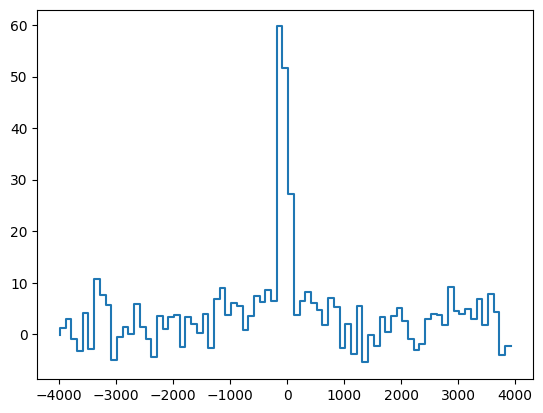

In [16]:
thisuid = 8219

for line in linelist.keys():
    if line not in ['Ha']:
    # if line not in ['Ha', 'OIII5007', 'Hb']:
        continue

    wavelength, veolcity_range = linelist[line]
    if 'prism' in k:
        veolcity_range = 90000
    # veolcity_range = 5000
    fit_line_id = str(thisuid) + ' ' + grating #+ '_' + line  
    fit_line = EmissionLineFitter(sp, z=z, reference_wavelength=wavelength, fit_line_id = fit_line_id)

veolcity_range = 4000
fit_line.slice_region(velocity_range=veolcity_range)

plt.step(fit_line.v_sliced, fit_line.flux_sliced)

6.7851
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_927271.spec.fits
fitting rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
1x3_G395M_Q3_PSFLib.fits
Gaussian 1:
  Flux      = 3.083e-18 ± 5.136e-19 erg/cm^2/s
  Luminosity= 1.708e+42 ± 2.845e+41 erg/s
  EW        = 174.01 ± 2.23 Å
  FWHM      = 220.26 ± 21.77 km/s
  intrinsic FWHM      = 142.98 ± 33.54 km/s
----------------------------------------
6.6202000000000005
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-nod-v3/rubies-egs53-nod-v3_prism-clear_4233_53254.spec.f

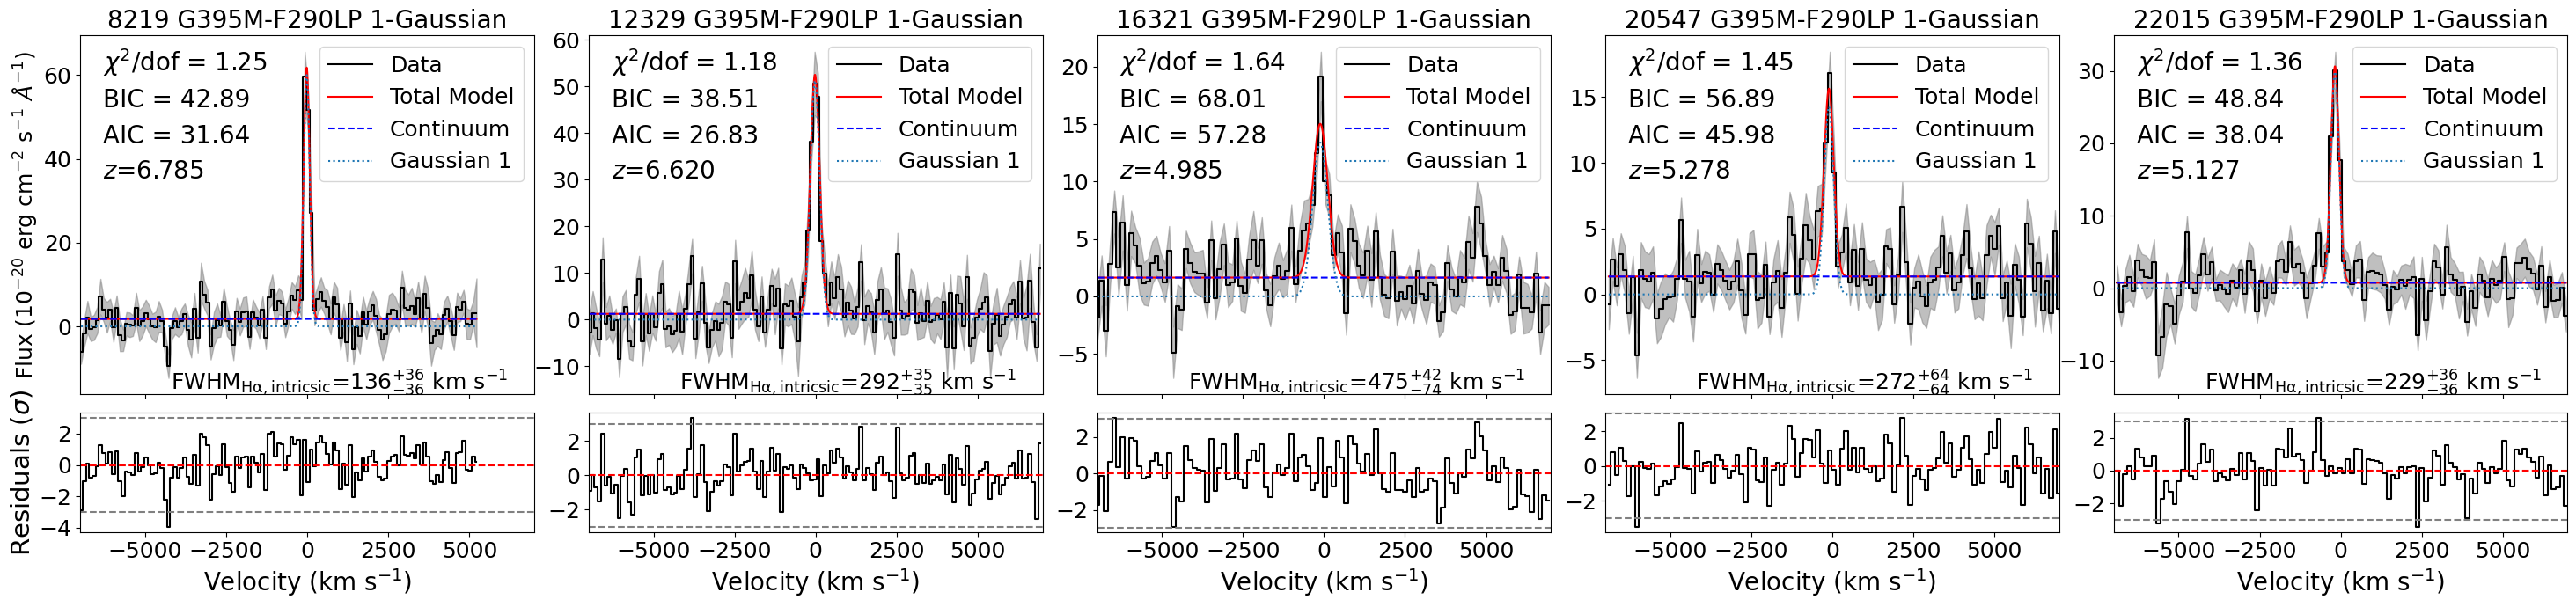

In [27]:
# line = 'Ha'
# narrowuidlist = [20773, 22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
# narrowuidlist = [22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
# five col subplots
fig, axess = plt.subplots(2, 5, figsize=(30, 7), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

c = const.c
src_IDs = [8219,12329,16321,20547,22015] #
for iii, thisuid in enumerate(src_IDs):
# for thisuid in jade_gal_uid:
    # if thisuid not in narrowuidlist:
    #      continue

    src = uid == thisuid
    # grating = Grating[src][0]

    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    sobj = {}
    for url in urls:
        while True:
            try:
                print(f'Read {url}')
                key = os.path.basename(url)
                sobj[key] = msaexp.spectrum.SpectrumSampler(url)
                break
            except:
                print('retry')
                continue
    for j, k in enumerate(sobj):
        if 'g395m' not in k and 'g395h' not in k and 'g235m' not in k:
        # if 'prism' not in k:
            continue
        if(thisuid == 8219 and j == 2):
            continue
        if(thisuid == 22015 and j == 4):
            continue
        

        print('fitting', k)
        sp = sobj[k]
        grating = k.split('_')[1].upper() #+ str(j)
        

        for line in linelist.keys():
            if line not in ['Ha']:
            # if line not in ['Ha', 'OIII5007', 'Hb']:
                continue

            wavelength, veolcity_range = linelist[line]
            if 'prism' in k:
                veolcity_range = 90000
            # veolcity_range = 5000
            fit_line_id = str(thisuid) + ' ' + grating #+ '_' + line  
            fit_line = EmissionLineFitter(sp, z=z, reference_wavelength=wavelength, fit_line_id = fit_line_id)

            # 截取波长范围
            veolcity_range = 7000
            fit_line.slice_region(velocity_range=veolcity_range)
            if(fit_line.v_sliced.size < 8 or fit_line.v_sliced[0]*fit_line.v_sliced[-1] > 0):
                print(f'fit_line.v_sliced.size < 8, skip {fit_line_id}')
                continue
            # 设置两个高斯成分

            #get initial mean
            argmax = np.argmax(fit_line.flux_sliced)
            initmean = fit_line.v_sliced[argmax]
            if 'prism' in k:
                #0.3989423*g1_amplitude/max(1e-15, g1_sigma)
                initial_params_br = [
                    {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(2000/2.35482), 'mean': initmean, 'stddev': 2000/2.35482, 
                                'mean_bounds': (-500, 500) , 'std_bounds': (1000/2.35482, 10000/2.35482), 'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced)) },
                    {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(1000/2.35482), 'mean': initmean, 'stddev': 1000/2.35482, 
                                'mean_bounds': (-500, 500) , 'std_bounds':(0, 4000/2.35482), 'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced)) }
                ]
            else:
                # 吸收成分参数
                abs_params = {
                    'amplitude': 0.3,  # 初始吸收深度30%
                    'mean': initmean - 500,  # 中心与发射线对齐
                    'stddev': 500/2.3548,
                    'amp_bounds': (0, 1),  # 强制约束在0-1
                    'mean_bounds': (initmean-300, initmean+300),
                    'std_bounds': (50/2.3548, 2000/2.3548)
                }
                # Ha-Ne II line
                initial_params_br = [
                    # {'amplitude': 5, 'mean': 0, 'stddev': 1000},
                    # {'amplitude': 5, 'mean': 50, 'stddev': 300},
                    # {'amplitude': max(fit_line.flux_sliced)*0.5, 'mean': 0, 'stddev': 500},
                    {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(100/2.35482), 'mean': initmean, 'stddev': 200/2.35482, 
                                'mean_bounds': (-1000, 1000) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced)), 'tied_sigma': None},  
                ]
            initial_params_sing = [
                {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(2000/2.35482), 'mean': 50, 'stddev': 500, 
                            'mean_bounds': (-200, 200) , 'std_bounds':(0, 2500/2.35482),'amp_bounds':(0, 1.5 * max(fit_line.flux_sliced))},
            ]
            if (line in ['Ha', 'Hb', 'MgII']):
                fit_line.set_gaussian_components(len(initial_params_br), initial_params_br)
            elif (line in ['OIII4959', 'OIII5007']):
                fit_line.set_gaussian_components(len(initial_params_sing), initial_params_sing)
            fit_line.fit_emission_line()
            fit_line.calculate_flux_ew_fwhm()
            # raise Exception('stop')
            
            fittry = 0
            fitdone = False
            candifluxamp = [[1,1], [0.8, 0.2], [0.5, 0.5], [0.2, 0.8], [0.1, 0.9], [0.3, 0.3], [0.9, 0.9], [0.1, 0.1], [0.5, 0.5], [0.8, 0.2]]

            # fit_line.save_fit_plot(img_save_path + fit_line_id + f'-{len(fit_line.gaussians)}-Gaussian' + '.png', ifshow = False)
            fit_line.external_plot([axess[0][src_IDs.index(thisuid)], axess[1][src_IDs.index(thisuid)]])
            axess[0][src_IDs.index(thisuid)].text(0.2, 0.01, r'$\rm FWHM_{\rm H \alpha,intricsic}$=' + r'$%.0f^{+%.0f}_{-%.0f}~\rm km~s^{-1}$' % (fwhm[iii], fwhm_up[iii], fwhm_down[iii]), transform=axess[0][src_IDs.index(thisuid)].transAxes, fontsize=18)
            axess[0][src_IDs.index(thisuid)].text(0.05, 0.6, r'$z$=' + '%.3f' % z, transform=axess[0][src_IDs.index(thisuid)].transAxes, fontsize=20)

            if(src_IDs.index(thisuid) == 0):
                axess[0][src_IDs.index(thisuid)].set_ylabel(r"Flux ($10^{-20}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)", fontsize=18)
                axess[1][src_IDs.index(thisuid)].set_ylabel("Residuals ($\sigma$)", fontsize=21)
plt.tight_layout()
# 减小子图间距
plt.subplots_adjust(wspace=0.12)
plt.savefig('/Users/zijianzhang/Astro_Data/LRD_SPEC/Figure/' + 'Ha_fitting.pdf', bbox_inches='tight', dpi = 300)
plt.show()
